In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
from utils import *
from settings import station_locale, data_root, output_folder, report_folder

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
data_folder = '../outputs/'
report_folder = '../report_rc/'

## Load Data & EDA & Processing

In [4]:
aq_df = pd.read_csv(os.path.join(data_folder, 'air_quality_no_duplicates.zip'))
gw_df = pd.read_csv(os.path.join(data_folder, 'grid_weather_processed.zip'))
ow_df = pd.read_csv(os.path.join(data_folder, 'ob_weather_processded.zip'))

In [5]:
aq_df = aq_df.drop(['Unnamed: 0'], axis=1)
gw_df = gw_df.drop(['Unnamed: 0'], axis=1)
ow_df = ow_df.drop(['Unnamed: 0'], axis=1)

In [5]:
aq_df.head()

,station_id,PM2.5,PM10,NO2,CO,O3,SO2,CO3,longitude,latitude,local_time,date,time,solar_term,time_label,NearTraffic,Others,SubUrban,Urban,datetime_label
0,aotizhongxin_aq,453.0,467.0,156.0,7.2,3.0,9.0,29.428746,116.397,39.982,2017-01-01 22:00:00,2017-01-01,22:00:00,7,4,0,0,0,1,0
1,aotizhongxin_aq,417.0,443.0,143.0,6.8,2.0,8.0,37.000000,116.397,39.982,2017-01-01 23:00:00,2017-01-01,23:00:00,7,3,0,0,0,1,1
2,aotizhongxin_aq,395.0,467.0,141.0,6.9,3.0,8.0,40.285393,116.397,39.982,2017-01-02 00:00:00,2017-01-02,00:00:00,7,2,0,0,0,1,2
3,aotizhongxin_aq,420.0,484.0,139.0,7.4,3.0,9.0,28.142929,116.397,39.982,2017-01-02 01:00:00,2017-01-02,01:00:00,7,1,0,0,0,1,3
4,aotizhongxin_aq,453.0,520.0,157.0,7.6,4.0,9.0,38.856791,116.397,39.982,2017-01-02 02:00:00,2017-01-02,02:00:00,7,0,0,0,0,1,4


In [6]:
gw_df.head()

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,date,time,solar_term,time_label,datetime_label
0,beijing_grid_000,115.0,39.0,2017-01-01 08:00:00,-5.47,984.73,76.60,53.71,3.53,2017-01-01,08:00:00,7,6,0
1,beijing_grid_001,115.0,39.1,2017-01-01 08:00:00,-5.53,979.33,75.40,43.59,3.11,2017-01-01,08:00:00,7,6,0
2,beijing_grid_002,115.0,39.2,2017-01-01 08:00:00,-5.70,963.14,71.80,0.97,2.75,2017-01-01,08:00:00,7,6,0
3,beijing_grid_003,115.0,39.3,2017-01-01 08:00:00,-5.88,946.94,68.20,327.65,3.84,2017-01-01,08:00:00,7,6,0
4,beijing_grid_004,115.0,39.4,2017-01-01 08:00:00,-5.34,928.80,58.81,317.85,6.14,2017-01-01,08:00:00,7,6,0


In [7]:
ow_df.head()

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather,date,time,solar_term,time_label,datetime_label
0,shunyi_meo,116.615278,40.126667,2017-01-31 00:00:00,-1.7,1028.7,15.0,215.0,1.6,Sunny/clear,2017-01-31,00:00:00,9,2,0
1,shunyi_meo,116.615278,40.126667,2017-01-31 01:00:00,-3.5,1028.4,24.0,16.0,1.0,Haze,2017-01-31,01:00:00,9,1,1
2,shunyi_meo,116.615278,40.126667,2017-01-31 02:00:00,-3.7,1028.1,27.0,32.0,1.1,Haze,2017-01-31,02:00:00,9,0,2
3,shunyi_meo,116.615278,40.126667,2017-01-31 03:00:00,-3.9,1027.6,27.0,21.0,0.9,Haze,2017-01-31,03:00:00,9,1,3
4,shunyi_meo,116.615278,40.126667,2017-01-31 04:00:00,-4.1,1026.7,26.0,17.0,1.1,Haze,2017-01-31,04:00:00,9,2,4


### Temperature & Pressure & Humidity Transfer

In [6]:
df_indicator = gw_df[['longitude', 'latitude', 'local_time', 'temperature', 'pressure', 'humidity']]
df_indicator = df_indicator.append(ow_df[['longitude', 'latitude', 'local_time', 'temperature', 'pressure', 'humidity']])

In [7]:
df_indicator.head()

,longitude,latitude,local_time,temperature,pressure,humidity
0,115.0,39.0,2017-01-01 08:00:00,-5.47,984.73,76.60
1,115.0,39.1,2017-01-01 08:00:00,-5.53,979.33,75.40
2,115.0,39.2,2017-01-01 08:00:00,-5.70,963.14,71.80
3,115.0,39.3,2017-01-01 08:00:00,-5.88,946.94,68.20
4,115.0,39.4,2017-01-01 08:00:00,-5.34,928.80,58.81


In [8]:
datetime_labeler = LabelEncoder()
df_indicator['datetime_label'] = datetime_labeler.fit_transform(df_indicator['local_time'])
aq_df['datetime_label'] = datetime_labeler.transform(aq_df['local_time'])

In [9]:
neibours = 7
weight = 'distance' # 'uniform', 'distance'

train_x = df_indicator[['longitude', 'latitude', 'datetime_label']]
train_y = df_indicator[['temperature']]
knn_temperature = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
knn_temperature.fit(train_x, train_y)

train_x = df_indicator[['longitude', 'latitude', 'datetime_label']]
train_y = df_indicator[['pressure']]
knn_pressure = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
knn_pressure.fit(train_x, train_y)

train_x = df_indicator[['longitude', 'latitude', 'datetime_label']]
train_y = df_indicator[['humidity']]
knn_humidity = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
knn_humidity.fit(train_x, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='distance')

In [10]:
aq_df['temperature'] = knn_temperature.predict(aq_df[['longitude', 'latitude', 'datetime_label']])
aq_df['pressure'] = knn_pressure.predict(aq_df[['longitude', 'latitude', 'datetime_label']])
aq_df['humidity'] = knn_humidity.predict(aq_df[['longitude', 'latitude', 'datetime_label']])

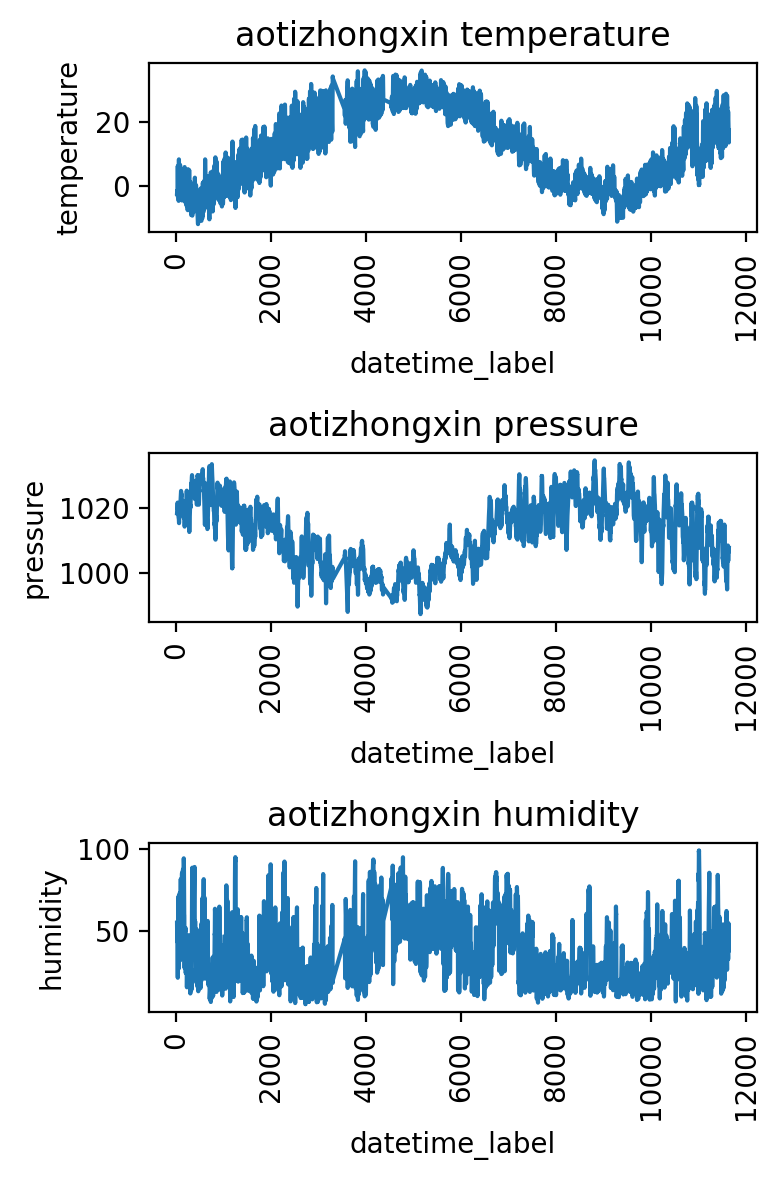

In [47]:
indicator = ['temperature', 'pressure', 'humidity']
temp = aq_df.query('station_id=="aotizhongxin_aq"')

plt.figure(figsize=(4,6), dpi=200)
i = 1
for indic in indicator:
    plt.subplot(3,1,i)
    plt.plot(temp['datetime_label'], temp[indic])
    plt.title(f'aotizhongxin {indic}')
    plt.ylabel(indic)
    plt.xlabel('datetime_label')
    plt.xticks(rotation=90)
    i+=1
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'atzx_weather_indocators_year.png'))
plt.show()

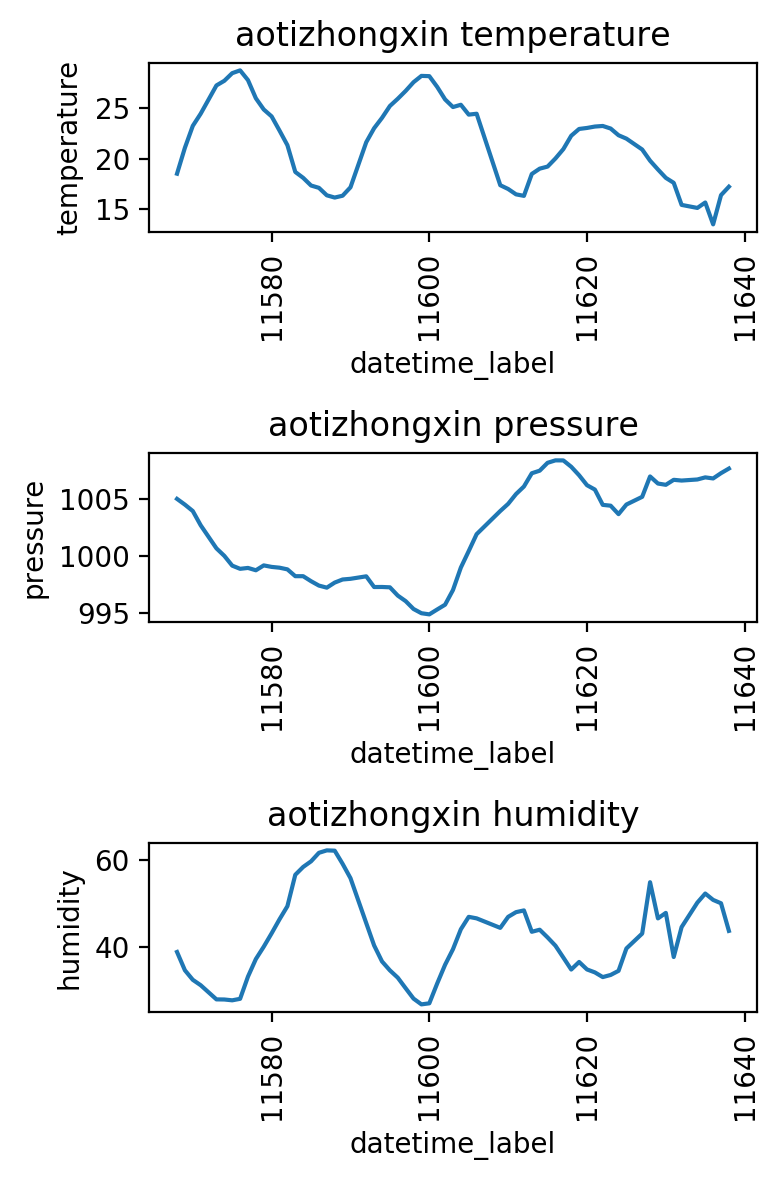

In [11]:
indicator = ['temperature', 'pressure', 'humidity']
temp = aq_df.query('station_id=="aotizhongxin_aq" and datetime_label >= 11568')

plt.figure(figsize=(4,6), dpi=200)
i = 1
for indic in indicator:
    plt.subplot(3,1,i)
    plt.plot(temp['datetime_label'], temp[indic])
    plt.title(f'aotizhongxin {indic}')
    plt.ylabel(indic)
    plt.xlabel('datetime_label')
    plt.xticks(rotation=90)
    i+=1
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'atzx_weather_indocators_day.png'))
plt.show()

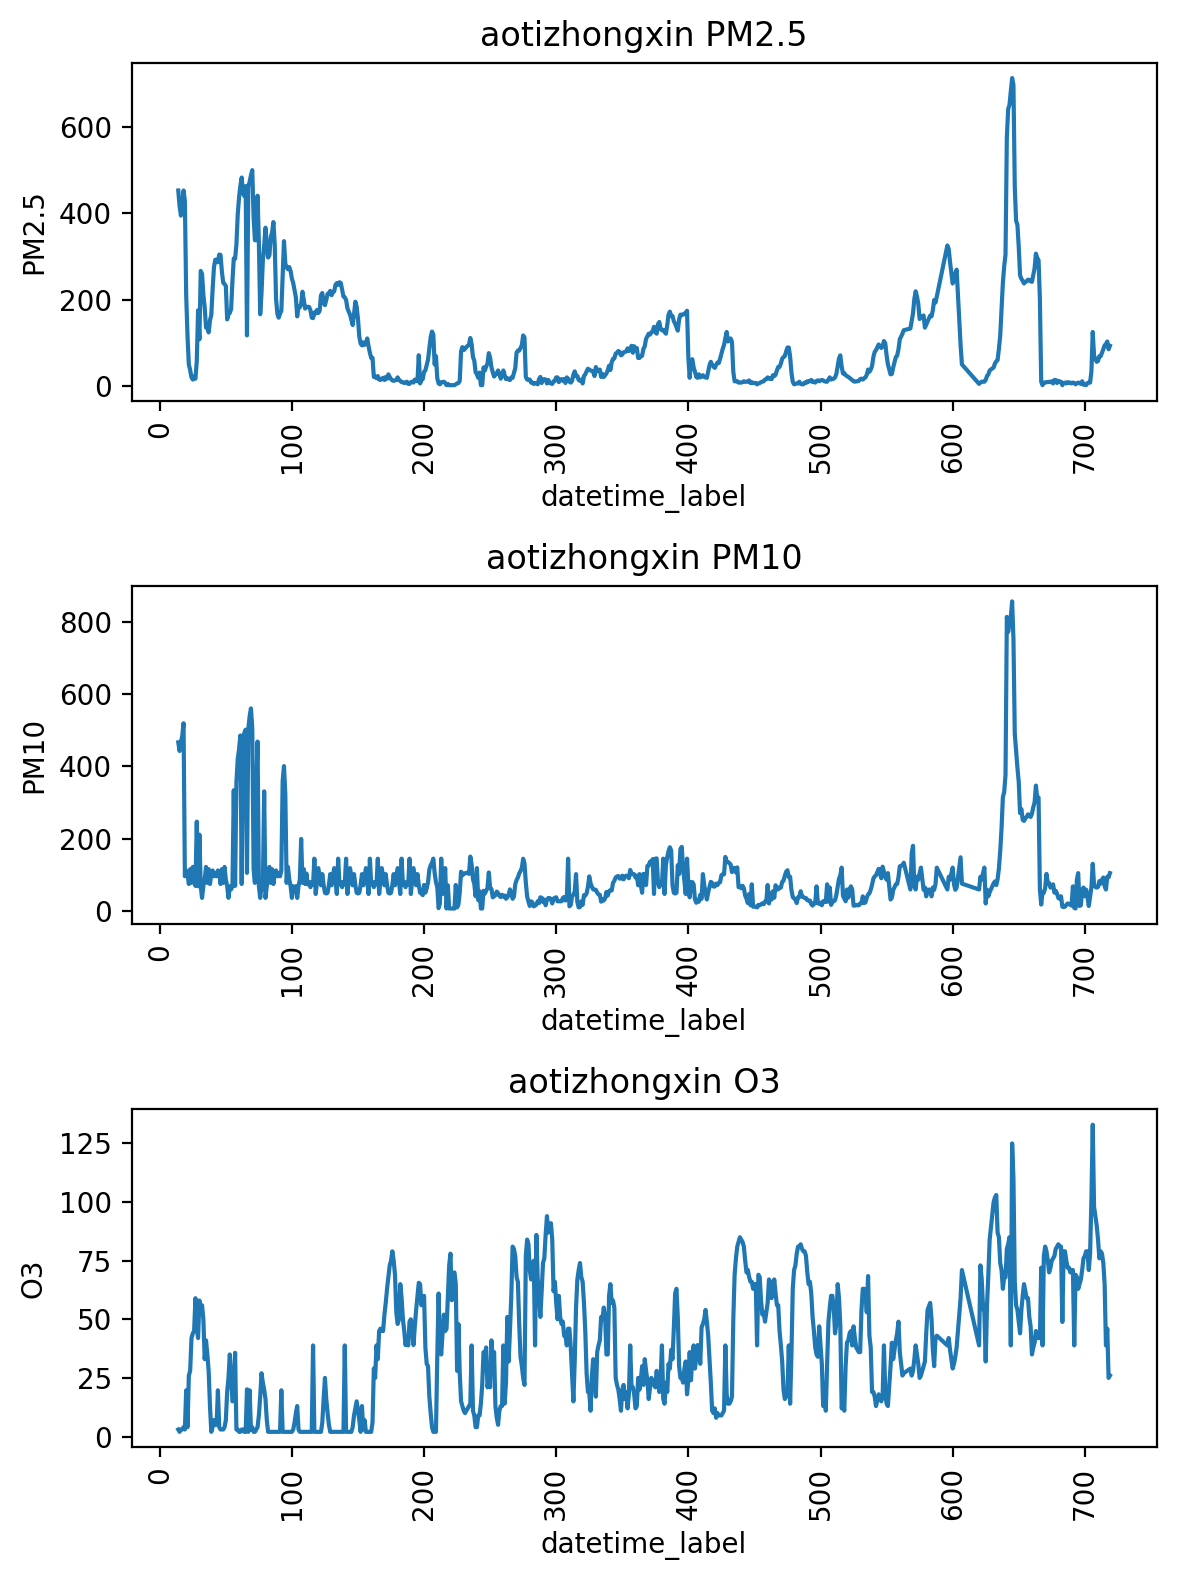

In [43]:
indicator = ['PM2.5', 'PM10', 'O3']
temp = aq_df.query('station_id=="aotizhongxin_aq" and datetime_label<720')

plt.figure(figsize=(6,8), dpi=200)
i = 1
for indic in indicator:
    plt.subplot(3,1,i)
    plt.plot(temp['datetime_label'], temp[indic])
    plt.title(f'aotizhongxin {indic}')
    plt.ylabel(indic)
    plt.xlabel('datetime_label')
    plt.xticks(rotation=90)
    i+=1
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'atzx_air_quanlities.png'))
plt.show()

### Wind Transfer

In [11]:
df_indicator = gw_df[['longitude', 'latitude', 'local_time', 'wind_direction', 'wind_speed']]
df_indicator = df_indicator.append(ow_df[['longitude', 'latitude', 'local_time', 'wind_direction', 'wind_speed']])

In [12]:
df_indicator[['wind_direction', 'wind_speed']].isna().any()

wind_direction    False
wind_speed        False
dtype: bool

In [13]:
print(df_indicator['wind_direction'].describe())
print(df_indicator['wind_speed'].describe())

count    7.694378e+06
mean     1.125771e+03
std      3.026672e+04
min      0.000000e+00
25%      1.323400e+02
50%      2.134200e+02
75%      3.012900e+02
max      9.999990e+05
Name: wind_direction, dtype: float64
count    7.694378e+06
mean     6.691391e+00
std      1.838223e+03
min      0.000000e+00
25%      1.455556e+00
50%      2.400000e+00
75%      3.852778e+00
max      9.999990e+05
Name: wind_speed, dtype: float64


In [14]:
datetime_labeler = LabelEncoder()
df_indicator['datetime_label'] = datetime_labeler.fit_transform(df_indicator['local_time'])
aq_df['datetime_label'] = datetime_labeler.transform(aq_df['local_time'])

In [15]:
neibours = 5
weight = 'distance' # 'uniform', 'distance'

train_x = df_indicator[['longitude', 'latitude', 'datetime_label']]
train_y = df_indicator[['wind_direction']]
knn = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
knn.fit(train_x, train_y)

aq_df['wind_direction'] = knn.predict(aq_df[['longitude', 'latitude', 'datetime_label']])

train_x = df_indicator[['longitude', 'latitude', 'datetime_label']]
train_y = df_indicator[['wind_speed']]
knn = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
knn.fit(train_x, train_y)

aq_df['wind_speed'] = knn.predict(aq_df[['longitude', 'latitude', 'datetime_label']])

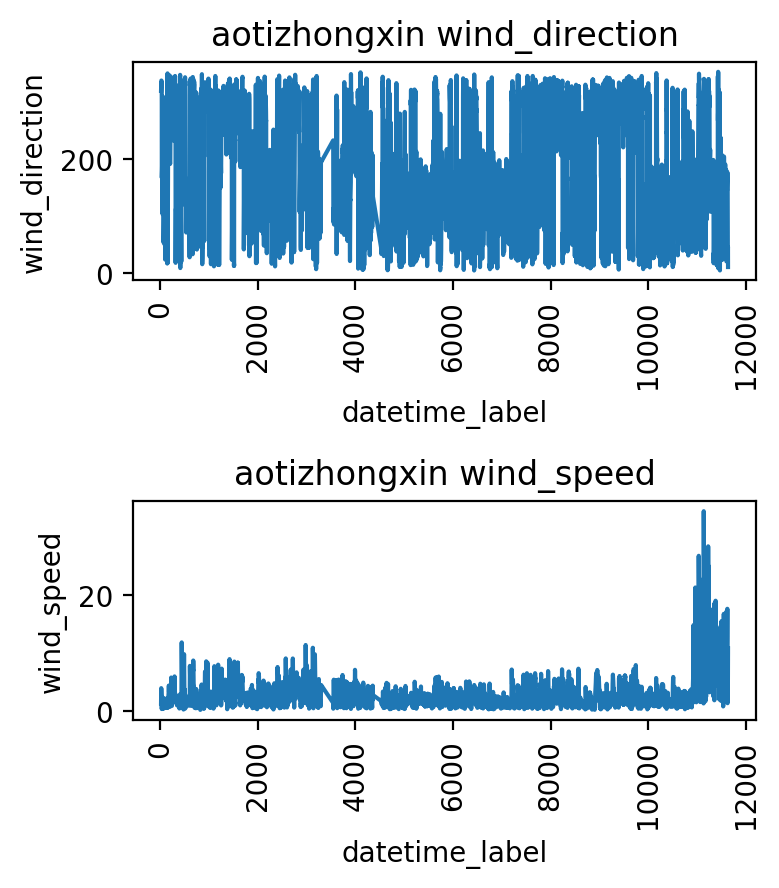

In [25]:
indicator = ['wind_direction', 'wind_speed']
temp = aq_df.query('station_id=="aotizhongxin_aq" and wind_direction < 360 and wind_speed < 480')

plt.figure(figsize=(4,6), dpi=200)
i = 1
for indic in indicator:
    plt.subplot(3,1,i)
    plt.plot(temp['datetime_label'], temp[indic])
    plt.title(f'aotizhongxin {indic}')
    plt.ylabel(indic)
    plt.xlabel('datetime_label')
    plt.xticks(rotation=90)
    i+=1
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'atzx_weather_indocators_year.png'))
plt.show()

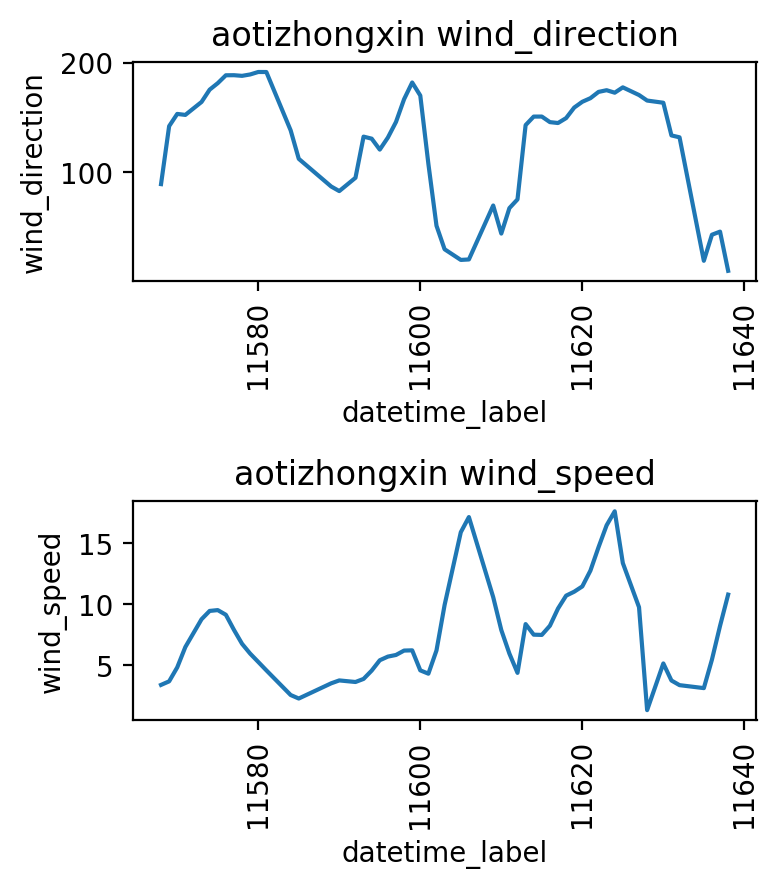

In [26]:
indicator = ['wind_direction', 'wind_speed']
temp = aq_df.query('station_id=="aotizhongxin_aq" and datetime_label >= 11568 and wind_direction < 360')

plt.figure(figsize=(4,6), dpi=200)
i = 1
for indic in indicator:
    plt.subplot(3,1,i)
    plt.plot(temp['datetime_label'], temp[indic])
    plt.title(f'aotizhongxin {indic}')
    plt.ylabel(indic)
    plt.xlabel('datetime_label')
    plt.xticks(rotation=90)
    i+=1
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'atzx_weather_indocators_day.png'))
plt.show()

In [16]:
aq_df

,station_id,PM2.5,PM10,NO2,CO,O3,SO2,longitude,latitude,local_time,...,NearTraffic,Others,SubUrban,Urban,datetime_label,temperature,pressure,humidity,wind_direction,wind_speed
0,aotizhongxin_aq,453.000000,467.000000,156.000000,7.200000,3.000000,9.000000,116.397,39.982,2017-01-01 22:00:00,...,0,0,0,1,14,-2.446930,1018.340389,55.292811,321.487278,1.277560
1,aotizhongxin_aq,417.000000,443.000000,143.000000,6.800000,2.000000,8.000000,116.397,39.982,2017-01-01 23:00:00,...,0,0,0,1,15,-2.270506,1018.574498,53.275542,328.980917,2.073301
2,aotizhongxin_aq,395.000000,467.000000,141.000000,6.900000,3.000000,8.000000,116.397,39.982,2017-01-02 00:00:00,...,0,0,0,1,16,-2.016952,1018.733522,50.109216,331.741163,2.680433
3,aotizhongxin_aq,420.000000,484.000000,139.000000,7.400000,3.000000,9.000000,116.397,39.982,2017-01-02 01:00:00,...,0,0,0,1,17,-1.761945,1018.895087,46.947844,333.396847,3.293645
4,aotizhongxin_aq,453.000000,520.000000,157.000000,7.600000,4.000000,9.000000,116.397,39.982,2017-01-02 02:00:00,...,0,0,0,1,18,-1.509102,1019.059065,43.782434,334.508356,3.905704
5,aotizhongxin_aq,429.000000,95.428571,141.000000,6.500000,3.000000,9.000000,116.397,39.982,2017-01-02 03:00:00,...,0,0,0,1,19,-1.808341,1019.301666,44.244828,336.106923,3.861264
6,aotizhongxin_aq,211.000000,111.571429,110.000000,3.300000,37.428571,11.000000,116.397,39.982,2017-01-02 04:00:00,...,0,0,0,1,20,-2.107474,1019.550670,44.702605,337.753435,3.821619
7,aotizhongxin_aq,116.000000,103.000000,87.000000,2.200000,4.000000,13.000000,116.397,39.982,2017-01-02 05:00:00,...,0,0,0,1,21,-2.409933,1019.795085,45.164920,339.429787,3.782533
8,aotizhongxin_aq,51.000000,74.000000,58.000000,1.300000,26.000000,14.000000,116.397,39.982,2017-01-02 06:00:00,...,0,0,0,1,22,-2.672708,1020.214293,44.964295,339.297863,3.549682
9,aotizhongxin_aq,38.000000,115.142857,55.000000,1.100000,28.000000,14.000000,116.397,39.982,2017-01-02 07:00:00,...,0,0,0,1,23,-2.937088,1020.634392,44.762753,339.143167,3.318540


In [17]:
aq_df.to_csv(os.path.join(output_folder, 'train_set.zip'), compression='zip')